In [23]:
server_url = 'grpcs://dalle-flow.dev.jina.ai'

prompt = 'green vanity with a marble shallow sink'


request sent: 2022-08-05 17:46:30.019326


response received: 2022-08-05 17:47:18.963157


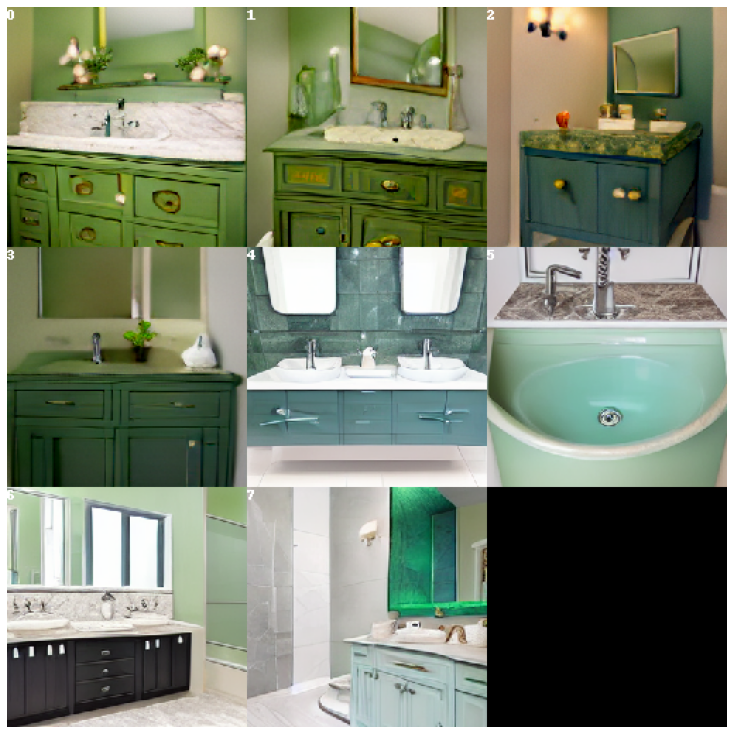

image processed: 2022-08-05 17:47:20.030317


In [24]:
from docarray import Document
from datetime import datetime

print('request sent:',datetime.now())
da = Document(text=prompt).post(server_url, parameters={'num_images': 4}).matches
print('response received:',datetime.now())
da.plot_image_sprites(fig_size=(10,10), show_index=True)
print('image processed:',datetime.now())


In [27]:
da

╭───────────────────────────────────── Documents Summary ──────────────────────────────────────╮
│                                                                                              │
│   Length                 8                                                                   │
│   Homogenous Documents   True                                                                │
│   Common Attributes      ('id', 'adjacency', 'mime_type', 'text', 'uri', 'tags', 'scores')   │
│   Multimodal dataclass   False                                                               │
│                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────╯
╭──────────────────────── Attributes Summary ─────────────────────────╮
│                                                                     │
│   Attribute   Data type          #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────────  │
│   adjacency   ('int',)           1                False             │
│   id          ('str',)           8                False             │
│   mime_type   ('str',)           1                False             │
│   scores      ('defaultdict',)   8                False             │
│   tags        ('dict',)          8                False             │
│   text        ('str',)           1                False             │
│   uri         ('str',)           8                False             │
│                                                                     │
╰─────────────────────────────────────────────────────────────────────╯

In [ ]:
### DALL-E-mini (text-to-images)

In [ ]:
## Google colab notebook
# https://colab.research.google.com/github/borisdayma/dalle-mini/blob/main/tools/inference/inference_pipeline.ipynb#scrollTo=SDjEx9JxR3v8

In [ ]:
## wandb
# https://wandb.ai/authorize
# 6d211aaa02fedb5b7386396c005eeca24f6ed4db

# From DALL-E-mini guide

In [1]:
!python3.7 -m pip install -r requirements.txt

  Cloning https://github.com/patil-suraj/vqgan-jax.git (to revision 10ef240f8ace869e437f3c32d14898f61512db12) to /private/var/folders/bb/z4nc_k_s4kv89y0pr4s_cx_00000gn/T/pip-install-lluptip6/vqgan-jax_1edfdb5bd79b430fb6a565dfff872bd2
  Running command git clone --filter=blob:none --quiet https://github.com/patil-suraj/vqgan-jax.git /private/var/folders/bb/z4nc_k_s4kv89y0pr4s_cx_00000gn/T/pip-install-lluptip6/vqgan-jax_1edfdb5bd79b430fb6a565dfff872bd2
  Running command git rev-parse -q --verify 'sha^10ef240f8ace869e437f3c32d14898f61512db12'
  Running command git fetch -q https://github.com/patil-suraj/vqgan-jax.git 10ef240f8ace869e437f3c32d14898f61512db12
  Resolved https://github.com/patil-suraj/vqgan-jax.git to commit 10ef240f8ace869e437f3c32d14898f61512db12
  Preparing metadata (setup.py) ... done



[notice] A new release of pip available: 22.2 -> 22.2.2
[notice] To update, run: pip3.7 install --upgrade pip


In [2]:
## Install required libraries

# !python3.7 -m pip install -q dalle-mini
# !python3.7 -m pip install -q git+https://github.com/patil-suraj/vqgan-jax.git


In [1]:
# Model references

# dalle-mega
DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:latest"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None

# if the notebook crashes too often you can use dalle-mini instead by uncommenting below line
DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"


In [2]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()


1

In [3]:
# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)

# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)


wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... Done. 0:0:12.4


In [4]:
## Model parameters are replicated on each device for faster inference.

from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)


In [5]:
## Model functions are compiled and parallelized to take advantage of multiple devices.

from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)


In [6]:
## Keys are passed to the model on each device to generate unique inference per device.

import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)


In [7]:
## model requires processing prompts.

from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)


wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... Done. 0:0:10.6


In [9]:
## Making prompts

prompts = [
    "sunset over a lake in the mountains",
    "the Eiffel tower landing on the moon",
]

tokenized_prompts = processor(prompts)
tokenized_prompt = replicate(tokenized_prompts)



Prompts: ['sunset over a lake in the mountains', 'the Eiffel tower landing on the moon']



/Users/Alex/opt/anaconda3/lib/python3.7/site-packages/jax/_src/ops/scatter.py:90: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float16 to dtype=float32. In future JAX releases this will result in an error.
  FutureWarning)


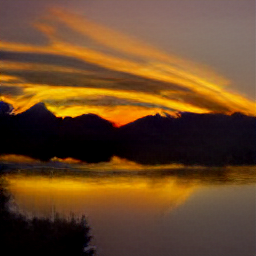

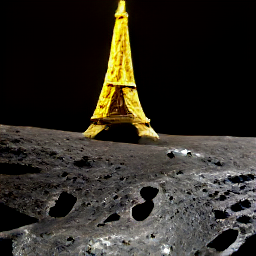

In [ ]:
# number of predictions per prompt
n_predictions = 8

# We can customize generation parameters (see https://huggingface.co/blog/how-to-generate)
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange

print(f"Prompts: {prompts}\n")
# generate images
images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
    # get a new key
    key, subkey = jax.random.split(key)
    # generate images
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
    # decode images
    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for decoded_img in decoded_images:
        img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
        images.append(img)
        display(img)
        print()
        

In [ ]:
# ## Rank by CLIP score

# # CLIP model
# CLIP_REPO = "openai/clip-vit-base-patch32"
# CLIP_COMMIT_ID = None

# # Load CLIP
# clip, clip_params = FlaxCLIPModel.from_pretrained(
#     CLIP_REPO, revision=CLIP_COMMIT_ID, dtype=jnp.float16, _do_init=False
# )
# clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
# clip_params = replicate(clip_params)

# # score images
# @partial(jax.pmap, axis_name="batch")
# def p_clip(inputs, params):
#     logits = clip(params=params, **inputs).logits_per_image
#     return logits


# from flax.training.common_utils import shard

# # get clip scores
# clip_inputs = clip_processor(
#     text=prompts * jax.device_count(),
#     images=images,
#     return_tensors="np",
#     padding="max_length",
#     max_length=77,
#     truncation=True,
# ).data
# logits = p_clip(shard(clip_inputs), clip_params)

# # organize scores per prompt
# p = len(prompts)
# logits = np.asarray([logits[:, i::p, i] for i in range(p)]).squeeze()


In [ ]:
# ## Display images ranked by clip score

# for i, prompt in enumerate(prompts):
#     print(f"Prompt: {prompt}\n")
#     for idx in logits[i].argsort()[::-1]:
#         display(images[idx * p + i])
#         print(f"Score: {jnp.asarray(logits[i][idx], dtype=jnp.float32):.2f}\n")
#     print()
    